# Segundo trabalho de processamento de imagens 2021.1

In [2]:
import cv2 # processamento de imagens
import numpy as np # funções numéricas
import matplotlib.pyplot as plt # visualização
from PIL import Image  # processamento de imagens
import requests # requisições HTTP

# Montando o google drive, onde as imagens usadas foram colocadas (mesma pasta do notebook)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 - Abra uma imagem e faça as quantizações para: 128, 64, 32, 16, 8 e 2 níveis de cinza.

In [3]:
def url_to_image(url):
  """
  Faz o download da imagem, converte em np.array e abre usando o OpenCV
  """
  resp = requests.get(url, stream=True)
  image = Image.open(resp.raw)

  return image

pil_lenna = np.array(url_to_image("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"))

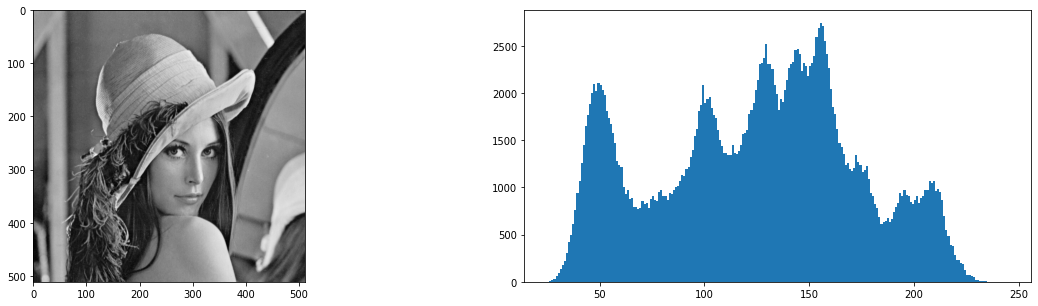

In [ ]:
# usando apenas um canal 
gray = cv2.cvtColor(pil_lenna, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.imshow(gray, cmap = "gray")
plt.subplot(1,2,2)
plt.hist(gray.ravel(), bins = abs(gray.max() - gray.min())); # o número de bins é o número de intensidades diferentes

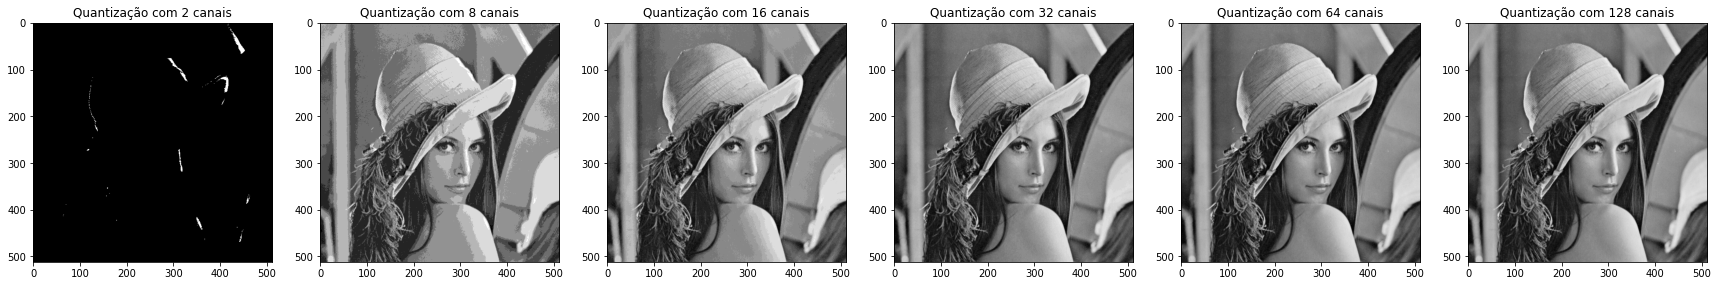

In [ ]:
def quantize(gray_img, quantization = 4):
  """
  Função de quantização de uma imagem em níveis de cinza
  """
  # pega os valores mínimos e máximos 
  min = gray.min()
  max = gray.max()

  # número de intensidades entre os valores máximo e mínimo
  min_max = abs(max - min)

  # número o qual seria dividido pela imagem, gerando o número exato de canais exigidos pela quantização
  n = min_max/(quantization-1)

  # ao dividir a imagem por n, teremos apenas o número de canais em valores possíveis
  q_img = np.uint8(gray_img/(n))

  return q_img

#lista com os números de canais a serem usados
quantization_list = [2,8,16,32,64,128]

# tamanho do loop
range_num = len(quantization_list)

plt.figure(figsize = (30,15))

# cada loop plota a imagem com um determinado número de canais
for i in range(range_num):
  quantized_img = quantize(gray_img = gray, quantization = quantization_list[i])
  plt.subplot(1,range_num, i+1)
  plt.imshow(quantized_img, cmap  ="gray")
  plt.title("Quantização com {} canais".format(quantization_list[i]))

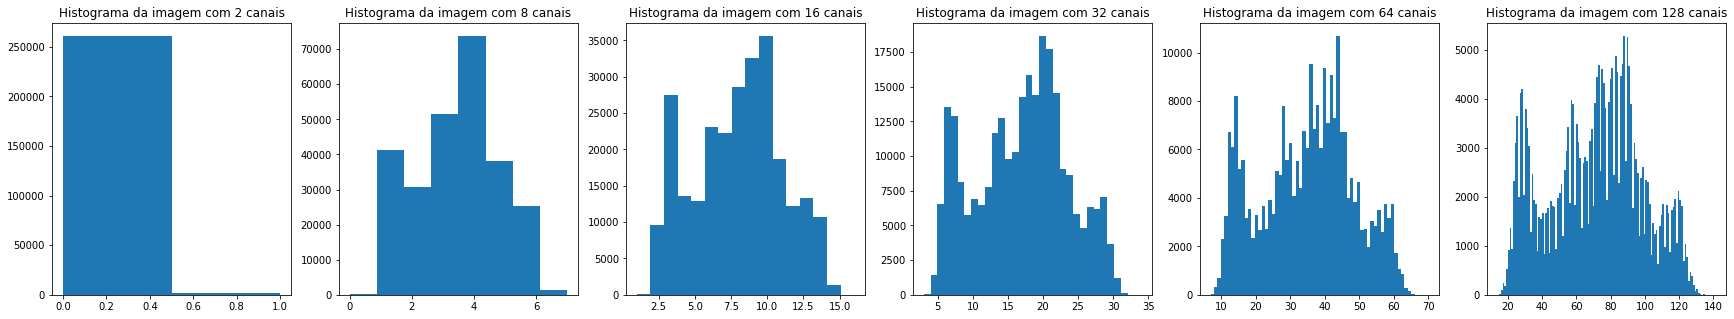

In [ ]:
 # plotando os histogramas
 plt.figure(figsize = (30,5))
 for i in range(range_num):
    quantized_img = quantize(gray_img = gray, quantization = quantization_list[i])
    plt.subplot(1,range_num, i+1)
    plt.hist(quantized_img.ravel(), bins = quantization_list[i])
    plt.title("Histograma da imagem com {} canais".format(quantization_list[i]))

## 2 - Abra a imagem (Fig0304(a)(breast_digital_Xray).tif) e aplique a transformação logarítmica.

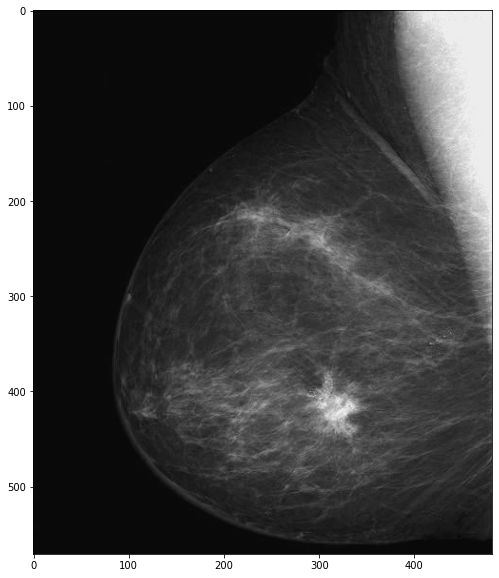

In [4]:
breast = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Fig0304(a)(breast_digital_Xray).tif"))
plt.figure(figsize = (10,10))
plt.imshow(breast, cmap = "gray");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


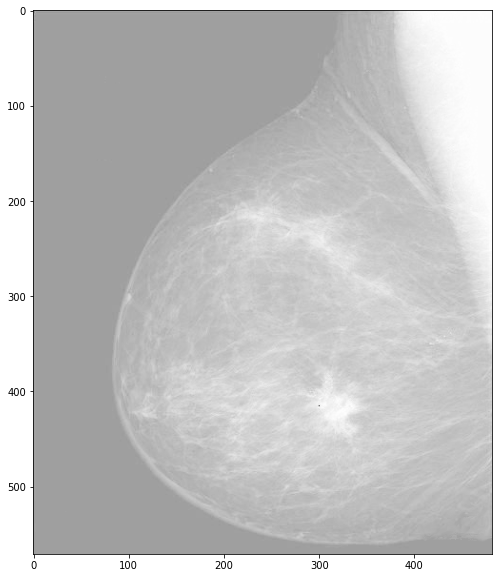

In [ ]:
def log_transform(img):
  # equação da transformação logarítimica de acordo com o livro do Gonzalez
  c = 255/(np.log(1 + img.max()))
  log_matrix = c*np.log(img + 1) 
  return log_matrix

plt.figure(figsize = (10,10))
# Aplicação da transformação logarítimca
log_breast = np.uint8(log_transform(breast))
plt.imshow(log_breast, cmap = "gray");

Text(0.5, 1.0, 'Histogama da imagem com transformação logarítimca')

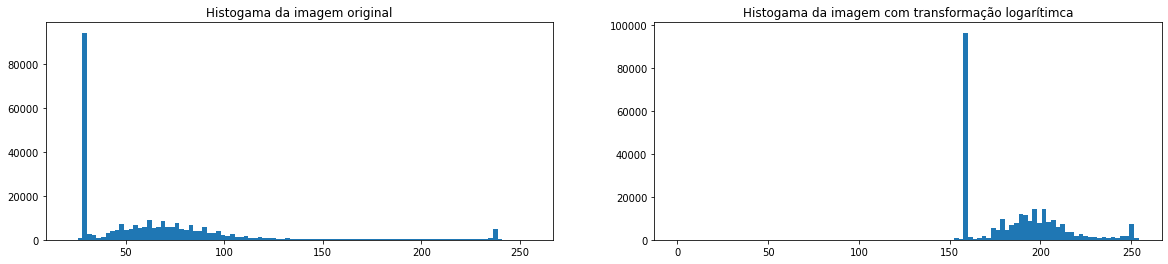

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,2,1)
plt.hist(breast.ravel(), bins = 100)
plt.title("Histogama da imagem original")

plt.subplot(1,2,2)
plt.hist(log_breast.ravel(), bins = 100)
plt.title("Histogama da imagem com transformação logarítimca")

## 3 - Aplique transformações de potência para os respectivos valores de gama: [0,2; 0,5; 1,0; 1,5; 2,0; 2,5].

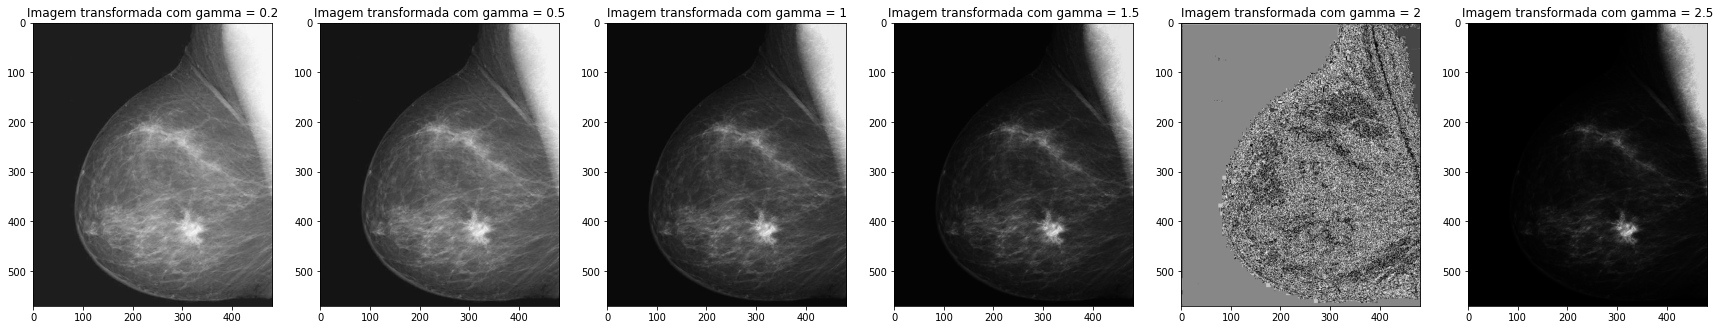

In [5]:
def gamma_transform(img, c = 1, gamma = 0.05):
  # usa a transformada gamma com a equação que está no livro do Gonzalez
  gamma_img = c * np.power(img,gamma)
  # coloca a imagem entre os valores de 0 e 255
  gamma_img = cv2.normalize(gamma_img, dst = None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX) 
  return gamma_img

#lista com os números de canais a serem usados
gamma_list = [0.2, 0.5, 1, 1.5, 2, 2.5]

# tamanho do loop
range_num = len(gamma_list)

plt.figure(figsize = (30,15))

# cada loop plota a imagem com um valor de gamma diferente
for i in range(range_num):
  transformed_img = gamma_transform(img = breast, c = 1, gamma = gamma_list[i])
  plt.subplot(1,range_num, i+1)
  plt.imshow(transformed_img, cmap  ="gray")
  plt.title("Imagem transformada com gamma = {}".format(gamma_list[i]))

Para valores de gama inteiros e maiores que 1, as imagens ficam todas como a quinta (gama = 2), muito ruidosa. Qualquer outro valor gera imagens sem ruído como as outras.

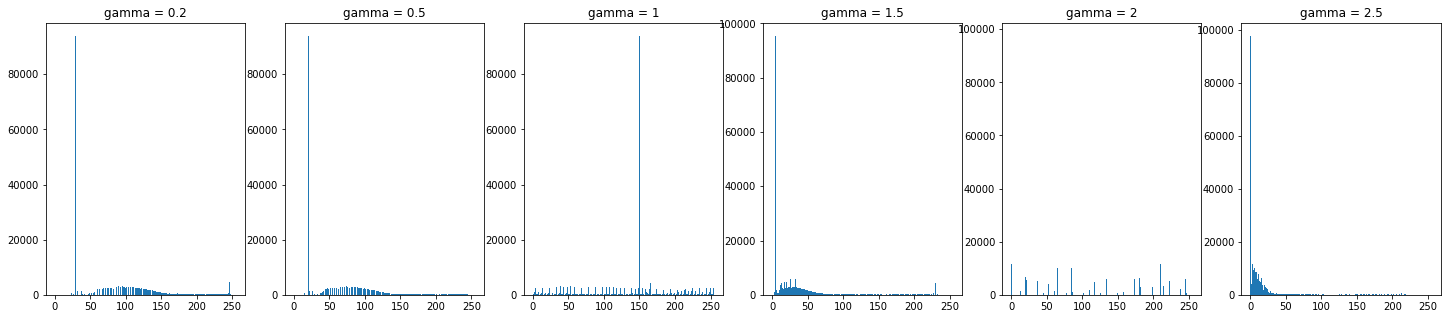

In [9]:
plt.figure(figsize = (25,5))
# cada loop plota o histograma da imagem com um valor de gamma diferente
for i in range(range_num):
  transformed_img = gamma_transform(img = breast, c = 5, gamma = gamma_list[i])
  plt.subplot(1,range_num, i+1)
  plt.hist(transformed_img.ravel(), bins = 256)
  plt.title("gamma = {}".format(gamma_list[i]))

## 4 - Faça uma limiarização com o limiar igual a média de intensidade.

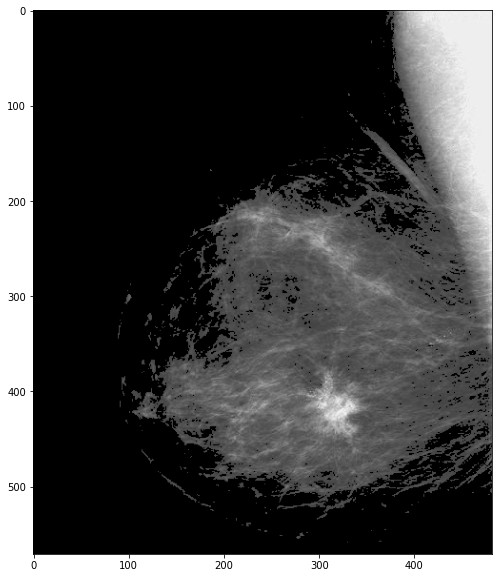

In [ ]:
def threshold_image(img, higher_or_lower = ""):
  """
  Retorna a imagem e a visualização com o limiar igual ao 
  valor de intensidade médio da imagem original aplicado.
  Dependendo do valor de higher_or_lower, pode usar os pixels
  acima ou abaixo do limiar
  """
  
  # intensidade média
  mean_int = img.mean()

  if higher_or_lower == "higher":
    # máscara contendo os valores maiores ou iguais ao limiar (média)
    thres_mask = np.uint(img >= mean_int)
  
  elif higher_or_lower == "lower":
    # máscara contendo os valores menores ou iguais ao limiar (média)
    thres_mask = np.uint(img < mean_int)

  else:
    print("`higher_or_lower` só pode ter valores iguais a 'higher' ou 'lower'")
    return 0

  # imagem com a máscara aplicada através da operação de multiplicação
  thres_image = img*thres_mask

  plt.figure(figsize = (10,10))
  plt.imshow(thres_image, cmap = "gray")

  return thres_image

thres_image = threshold_image(img = breast, higher_or_lower="higher")

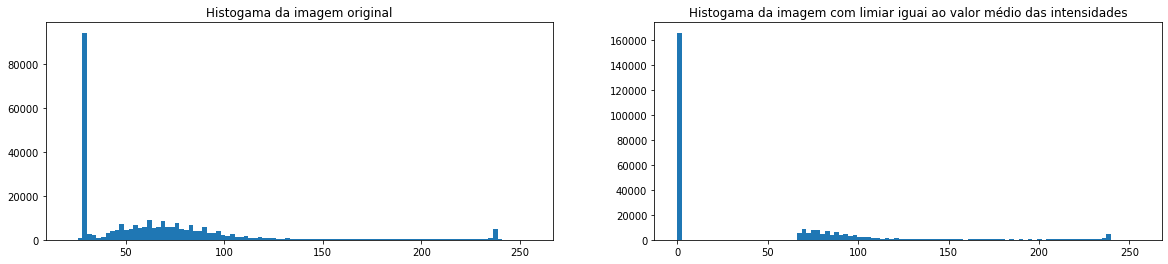

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,2,1)
plt.hist(breast.ravel(), bins = 100)
plt.title("Histogama da imagem original")

plt.subplot(1,2,2)
plt.hist(thres_image.ravel(), bins = 100)
plt.title("Histogama da imagem com limiar iguai ao valor médio das intensidades");

## 5 - Faça o uso da transformação por janela-nível em três partes do eixo de intensidade.

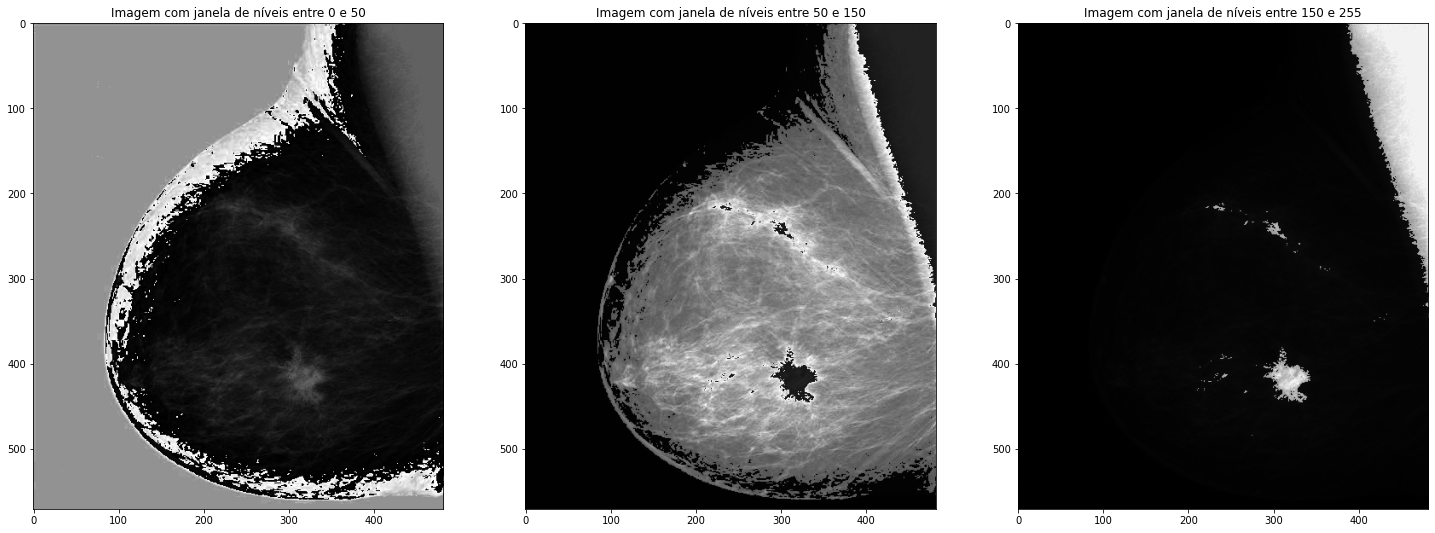

In [190]:
def window_level_transform(gray_img, lower_thres = 70, upper_thres = 90, intensity_scale = 5):

  """
  A função cria duas máscaras, uma em cada limite da janela. 
  As intensidades de fora dessa região serão multiplicados por 0.5 do 
  enquanto que as intensidades dentro da região serão multiplicadas por intensity_scale + 0.5.
  A ideia é utilizar uma função da forma da figura 3.11a do Gonzalez, onde a área da janela
  possui seus valores multiplicados por uma constante alta enquanto os pixels fora da janela 
  são multiplicados por um número baixo, de forma a realçar as intensidades da janela em questão.
  """
  # máscara com os valores maiores que o limite inferior da janela
  lower_mask = intensity_scale*np.uint8(gray_img >= lower_thres) + 0.5

  # máscara com os valores menores que o limite superior da janela
  upper_mask = intensity_scale*np.uint8(gray_img < upper_thres) + 0.5

  # a imagem transformada é a multiplicação elemento a elemento 
  # das máscaras com a imagem original
  transformed_img = upper_mask * lower_mask * gray_img

  return transformed_img

# janelas de intensidade
threshold_list = [(0,50), (50,150), (150,255)]

i = 0
plt.figure(figsize = (25,10))
# transforma a imagem e plota
for low, up in threshold_list:
  thres_img = window_level_transform(gray_img = breast, lower_thres = low, upper_thres = up)
  plt.subplot(1,len(threshold_list),i+1)
  plt.imshow(thres_img, cmap = "gray")
  plt.title("Imagem com janela de níveis entre {} e {}".format(low, up))
  i+=1

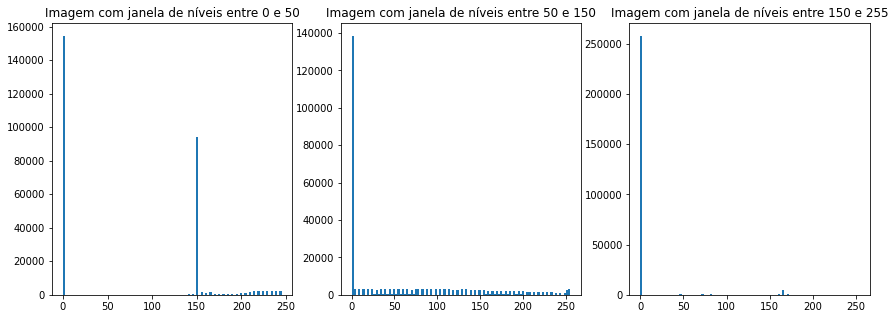

In [ ]:
# histogramas
plt.figure(figsize = (25,5))
# cada loop plota a imagem com um valor de gamma diferente
i = 0
for low, up in threshold_list:
  thres_img = window_level_transform(gray_img = breast, lower_thres = low, upper_thres = up)
  plt.subplot(1,range_num, i+1)
  plt.hist(thres_img.ravel(), bins = 100)
  plt.title("Imagem com janela de níveis entre {} e {}".format(low, up))
  i+=1

## 6 - Implemente e aplique a equalização de histograma.

In [ ]:
def histogram_equalization(img):
  """
  Essa função serve tanto para equalização de histograma quanto para o cálculo 
  de G(z), eq. 3.3-14 do livro do Gonzalez, uma das etapas na especificação de 
  histograma.
  """
  # colocando os pixels no intervalo (0, L-1), pois o valor mínimo não é zero
  img = img - img.min()
  MN = img.shape[0]* img.shape[1]
  L = img.max()

  # um array contendo cada intensidade e outro contendo o 
  # número de vezes que aquela intensidade aparece na imagem
  original_intensity, number_of_occurrence = np.unique(img, return_counts = True)

  # inicializando o array com as novas intensidades
  new_intensity = np.full(original_intensity.shape, 0)

  # criando o novo histograma
  for k in range(len(original_intensity)):
    j = 0
    cumulative_sum = 0
    while j <= k:
        cumulative_sum += number_of_occurrence[j]
        j+=1
    

    # a nova intensidade é dada pela equação 3.3-8 do livro do Gonzalez
    # usada para calcular T de um histograma uniforme (equalização)
    new_intensity[k] = (L-1)/MN * cumulative_sum

  # inicializando a nova imagem com zeros
  new_img = np.full(img.shape, 0)

  # trocando os pixels da imagem original pelos equalizados
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      # procura a posição da intensidade de um pixel da imagem original
      position_in_array = np.where(original_intensity == img[i][j])[0][0]

      # substitui pelo novo valor de intensidade
      new_img[i][j] = new_intensity[position_in_array]

  return  new_img, new_intensity, original_intensity



In [ ]:
new_image, new_int, original_intensity = histogram_equalization(img = breast)

array([[  0,  80,  82, ..., 232, 232, 232],
       [ 85,   0,  85, ..., 232, 232, 232],
       [ 84,   0,  90, ..., 232, 232, 232],
       ...,
       [ 81,  81,   1, ...,  80,  80,  80],
       [ 81,  81,   1, ...,  80,  80,  80],
       [ 81,  81,   1, ...,  80,  80,  80]])

Text(0.5, 1.0, 'Histograma equalizado')

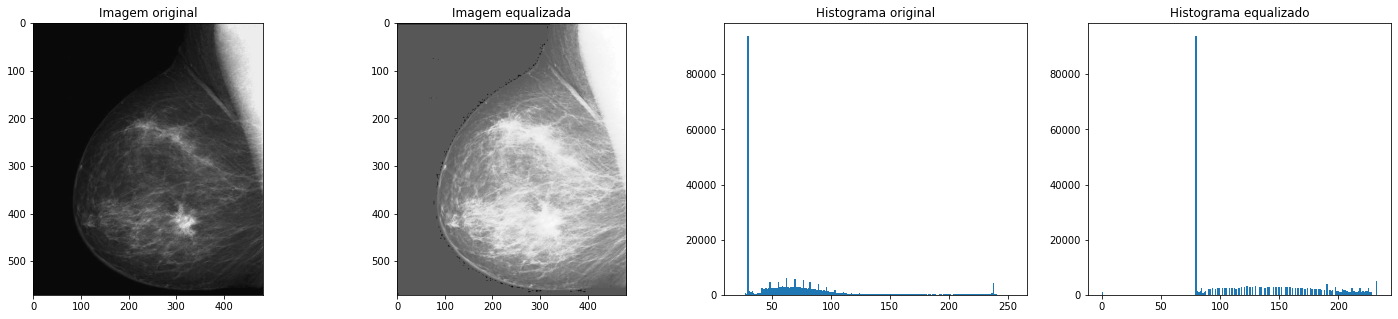

In [ ]:
# Visualizações
plt.figure(figsize = (25,5))

plt.subplot(1,4,1)
plt.imshow(breast, cmap = "gray")
plt.title("Imagem original")

plt.subplot(1,4,2)
plt.imshow(new_image, cmap = "gray")
plt.title("Imagem equalizada")

plt.subplot(1,4,3)
plt.hist(breast.ravel(), bins = 200);
plt.title("Histograma original")

plt.subplot(1,4,4)
plt.hist(new_image.ravel(), bins = 200);
plt.title("Histograma equalizado")

O histograma equalizado mostra os valores de intensidade mais uniformemente distribuídos. O pico continua, pois existem muitos pixels com valores próximos de 0 na imagem original.


## 7 - Implemente e aplique a especificação de histograma para um histograma de uma imagem de referência.

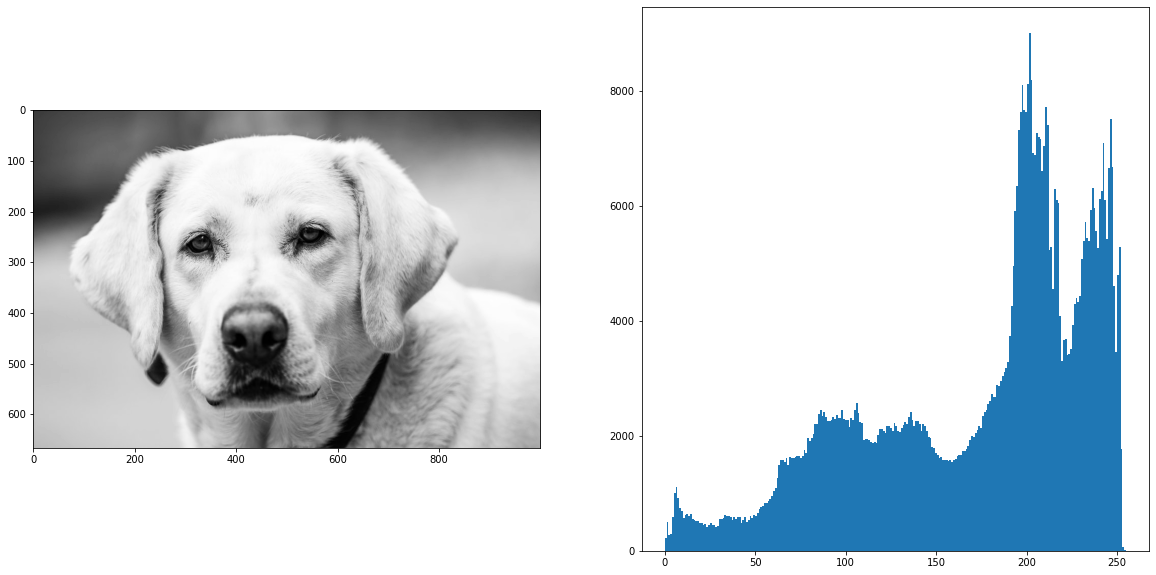

In [ ]:
# imagem de referência
reference_img = np.array(url_to_image("https://images.unsplash.com/photo-1580330849490-c8061834a72d?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1000&q=80"))
reference_img = cv2.cvtColor(reference_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.imshow(reference_img, cmap = "gray")

plt.subplot(1,2,2)
plt.hist(reference_img.ravel(),bins = 256);

In [ ]:
def find_nearest(array, value):
    """
    Função para achar o valor mais próximo. Muitas vezes o array de uma transformação é [0,0,0,1,1,2,3]
    e escolhemos, por convenção, o primeiro número que aparece na sequência. E.g: queremos a primeira posição
    em que aparece o número 1. Essa seria a posição 3.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

orig_img = breast

# colocando os pixels no intervalo (0, L-1), pois o valor mínimo não é zero
orig_img = orig_img - orig_img.min()

# Primeiro passo: equalizar o histograma da imagem original
equalized_img, eq_int, orig_int_eq = histogram_equalization(img = orig_img)

# Segundo passo: usar a equação 3.3-14 no histograma de referência para equalizá-la também
gz, esp_int, orig_int_ref = histogram_equalization(img = reference_img)

# Terceiro passo: fazer o mapeamento dos pixels da imagem original para o histograma de referência
# pixel original -> valor no histograma de equalização -> valor no histograma de referência G -> valor original de G


new_specified_image = np.full(orig_img.shape, 0)

for i in range(orig_img.shape[0]):
  for j in range(orig_img.shape[1]):
    # pega o pixel da imagem original e descobre o seu valor no histograma equalizado
    position_in_array = np.where(orig_int_eq == orig_img[i][j])[0][0]
    intermediate_px_value = eq_int[position_in_array]

    # procurar por um valor próximo ao do pixel intermediário
    nearest_intensity_value = find_nearest(esp_int, intermediate_px_value)

    # ver qual a localização do pixel com essa intensidade
    position_in_ref_array = np.where(esp_int == nearest_intensity_value)[0][0]
    
    # fazer o mapeamento inverso e descobrir o valor equivalente na imagem de referência
    new_specified_image[i][j] = orig_int_ref[position_in_ref_array]

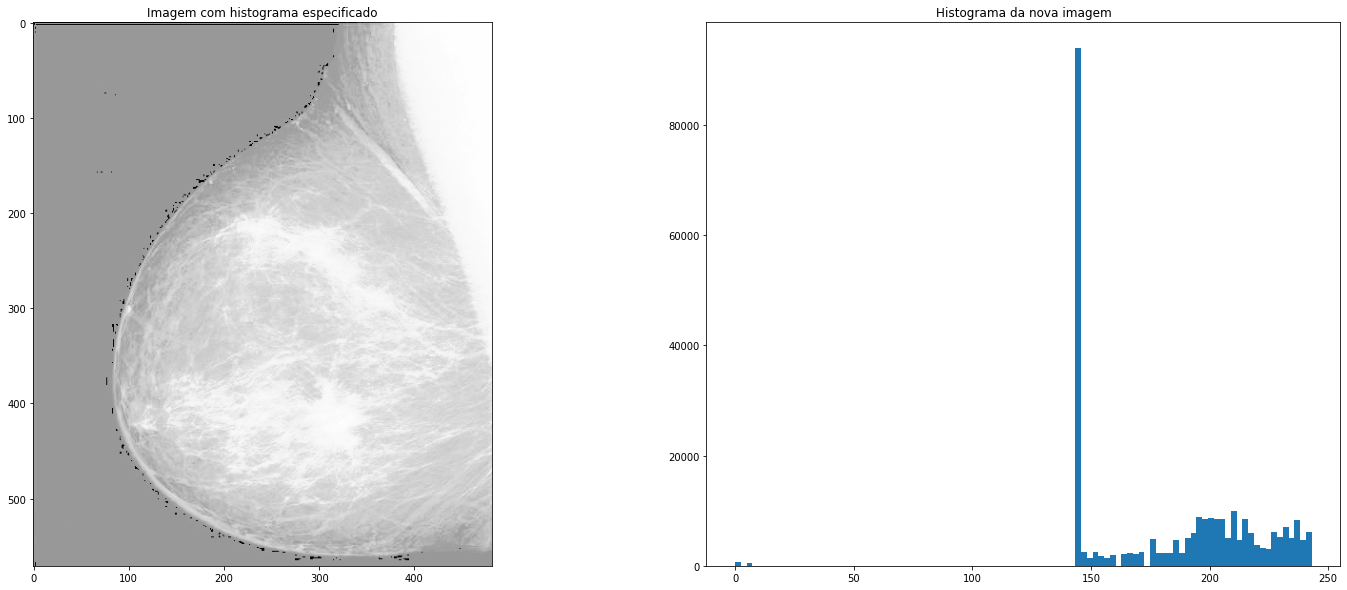

In [ ]:
plt.figure(figsize = (25,10))

plt.subplot(1,2,1)
plt.imshow(new_specified_image, cmap = "gray")
plt.title("Imagem com histograma especificado")

plt.subplot(1,2,2)
plt.hist(new_specified_image.ravel(), bins = 100)
plt.title("Histograma da nova imagem");

É possível observar que o formato do histograma da imagem modificada é parecido com o da imagem de referência, com dois picos maiores no final (um ao redor de 200 e outro ao redor de 230).

## 8 - Aplique a equalização de histograma e especificação de histograma a uma imagem com janelas 3x3 e 5x5.

### Equalização

In [ ]:
def adaptive_histogram_equalization(img, window_size = 3):

  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))

  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)
  for i in range(padded_img.shape[0] - pad_pixels):
    if i > pad_pixels - 1:
      for j in range(padded_img.shape[1] - pad_pixels):
        if j > pad_pixels - 1:
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized, _ , _ = histogram_equalization(window)
          
          new_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)] = equalized

  return new_img

In [ ]:
padded_breast_three = adaptive_histogram_equalization(img = breast, window_size = 3)
padded_breast_five = adaptive_histogram_equalization(img = breast, window_size = 5)
padded_breast_st = adaptive_histogram_equalization(img = breast, window_size = 15)

Text(0.5, 1.0, 'Equalização com janela 15x15')

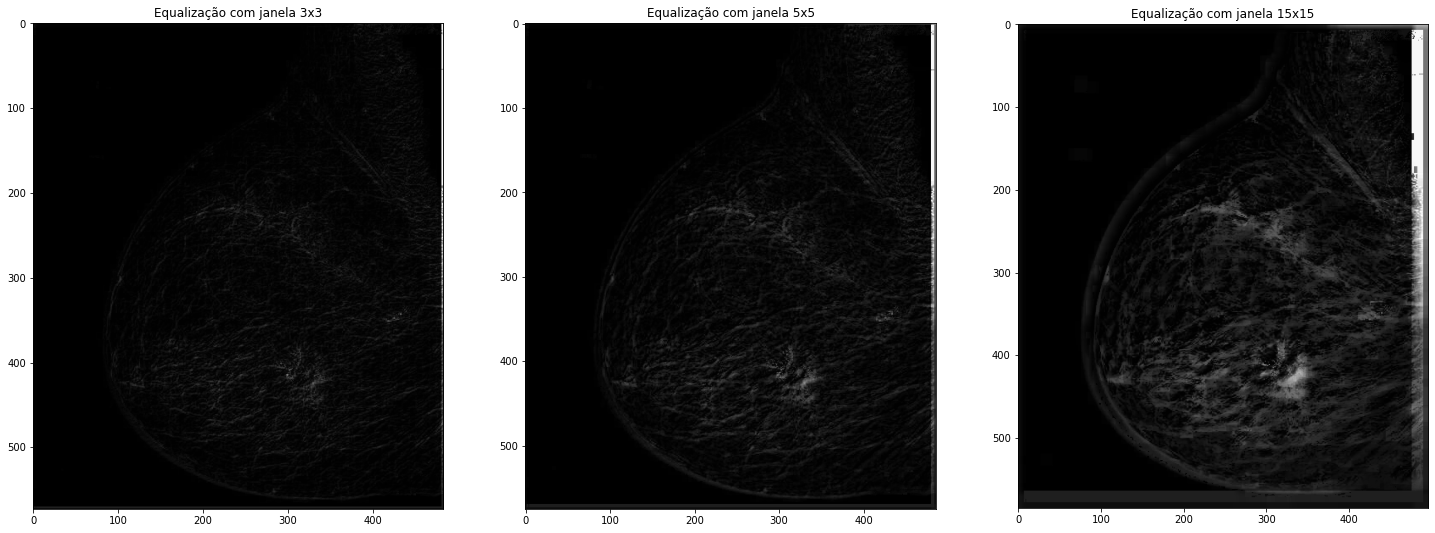

In [ ]:
plt.figure(figsize = (25,10))
plt.subplot(1,3,1)
plt.imshow(padded_breast_three, cmap = "gray")
plt.title("Equalização com janela 3x3")

plt.subplot(1,3,2)
plt.imshow(padded_breast_five, cmap = "gray")
plt.title("Equalização com janela 5x5")

plt.subplot(1,3,3)
plt.imshow(padded_breast_st, cmap = "gray")
plt.title("Equalização com janela 15x15")

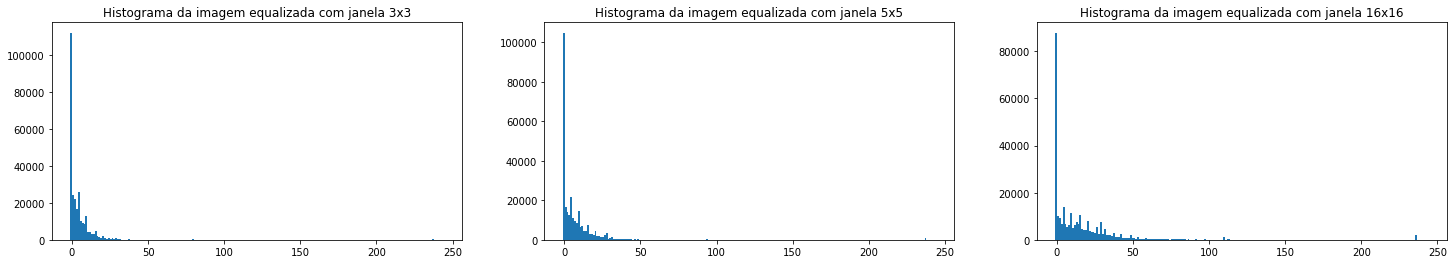

In [ ]:
plt.figure(figsize = (25,4))
plt.subplot(1,3,1)
plt.hist(padded_breast_three.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 3x3")

plt.subplot(1,3,2)
plt.hist(padded_breast_five.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 5x5")

plt.subplot(1,3,3)
plt.hist(padded_breast_st.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 16x16");

### Especificação

In [ ]:
def adaptive_specification(img, ref_img, window_size = 3):
  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))

  # adicionar bordas na referência
  padded_ref = np.pad(ref_img, pad_pixels, constant_values = (0))
  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)

  for i in range(padded_img.shape[0] - pad_pixels):
    if i > pad_pixels - 1:
      for j in range(padded_img.shape[1] - pad_pixels):
        if j > pad_pixels - 1:

          # equalizando a janela da imagem original
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized, eq_int , orig_int = histogram_equalization(window)

          # equalizando a janela da imagem de referência
          reference_window = padded_ref[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized_reference, ref_eq_int, ref_orig_int = histogram_equalization(window)

          # inicializando a janela onde ficarão as novas intensidades
          new_specified_window = np.full((window_size, window_size), 0)

          # colocando o mínimo da imagem no 0
          window = window - window.min()

          ## etapa de mapeamento das intensidades originais para as intensidades de referência
          for m in range(window.shape[0]):
            for n in range(window.shape[1]):

              # pega o pixel da janela na imagem original e descobre o seu valor no histograma equalizado local
              position_in_array = np.where(orig_int == window[m][n])[0][0]
              intermediate_px_value = eq_int[position_in_array]

              # procurar por um valor próximo ao do pixel intermediário
              nearest_intensity_value = find_nearest(ref_eq_int, intermediate_px_value)

              # ver qual a localização do pixel com essa intensidade
              position_in_ref_array = np.where(ref_eq_int == nearest_intensity_value)[0][0]
              
              # fazer o mapeamento inverso e descobrir o valor equivalente na imagem de referência
              new_specified_window[m][n] = ref_orig_int[position_in_ref_array]
      
          new_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)] = new_specified_window
  return new_img

In [ ]:
sp_breast_three = adaptive_specification(img = breast, ref_img = reference_img, window_size = 3)
sp_breast_five = adaptive_specification(img = breast, ref_img = reference_img, window_size = 5)
sp_breast_st = adaptive_specification(img = breast, ref_img = reference_img, window_size = 15)

Text(0.5, 1.0, 'Especificação com janela 15x15')

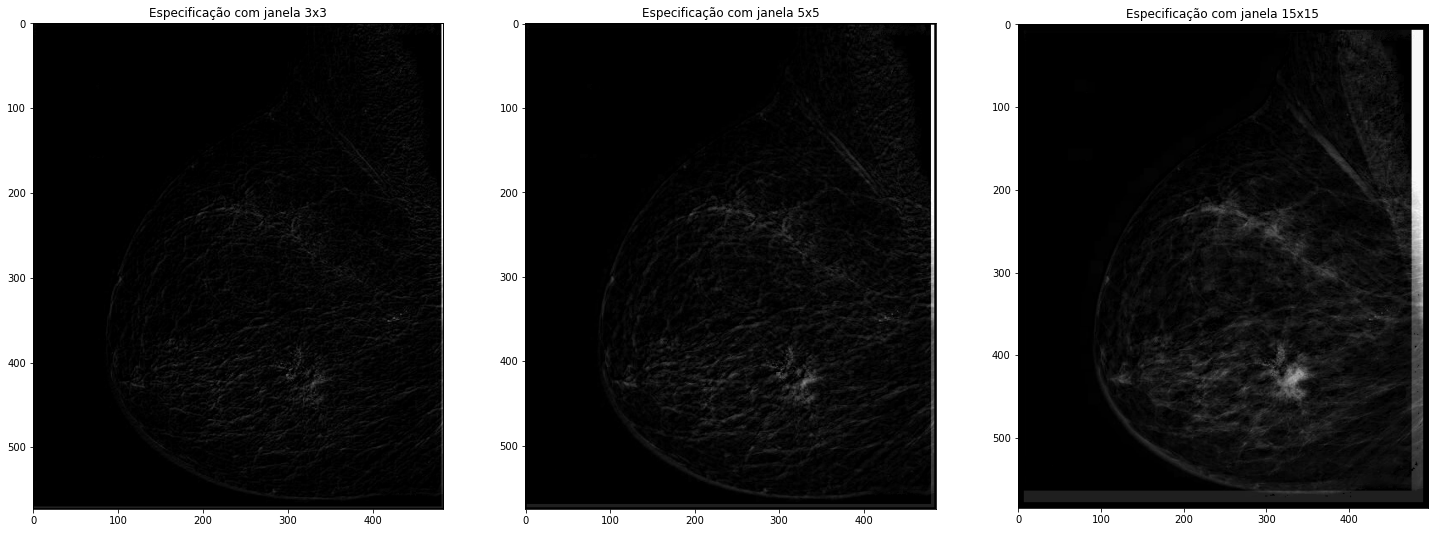

In [ ]:
plt.figure(figsize = (25,10))
plt.subplot(1,3,1)
plt.imshow(sp_breast_three, cmap = "gray")
plt.title("Especificação com janela 3x3")

plt.subplot(1,3,2)
plt.imshow(sp_breast_five, cmap = "gray")
plt.title("Especificação com janela 5x5")

plt.subplot(1,3,3)
plt.imshow(sp_breast_st, cmap = "gray")
plt.title("Especificação com janela 15x15")

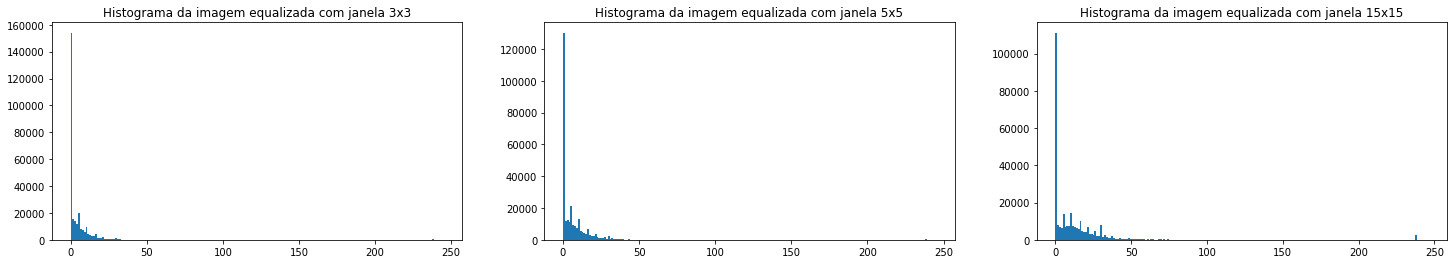

In [ ]:
plt.figure(figsize = (25,4))
plt.subplot(1,3,1)
plt.hist(sp_breast_three.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 3x3")

plt.subplot(1,3,2)
plt.hist(sp_breast_five.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 5x5")

plt.subplot(1,3,3)
plt.hist(sp_breast_st.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada com janela 15x15");

## 9 - Aplique a equalização de histograma e especificação de histograma a uma imagem com regiões não sobreposta

Aqui basta mudar um pouco as duas funções anteriores para não passar em regiões que já foram vistas antes.

### Equalização

In [ ]:
def adaptive_histogram_equalization_wo_overlap(img, window_size = 3):

  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # pixels para andar e evitar regiões sobrepostas
  walk_pixels = window_pixels + 1

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))

  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)
  
  for i in range(0, padded_img.shape[0] - pad_pixels, walk_pixels):
    if i > pad_pixels - 1:
      for j in range(0, padded_img.shape[1] - pad_pixels, walk_pixels):
        if j > pad_pixels - 1:

          # define a janela (kernel) e equaliza seus histogramas
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized, _ , _ = histogram_equalization(window)

          # nova imagem depois da equalização
          new_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)] = equalized

  return new_img

breast_eq_no_overlap_three = adaptive_histogram_equalization_wo_overlap(img = breast, window_size = 3)
breast_eq_no_overlap_five = adaptive_histogram_equalization_wo_overlap(img = breast, window_size = 5)
breast_eq_no_overlap_fft = adaptive_histogram_equalization_wo_overlap(img = breast, window_size = 15)


Text(0.5, 1.0, 'Equalização com janela 15x15 sem sobreposição')

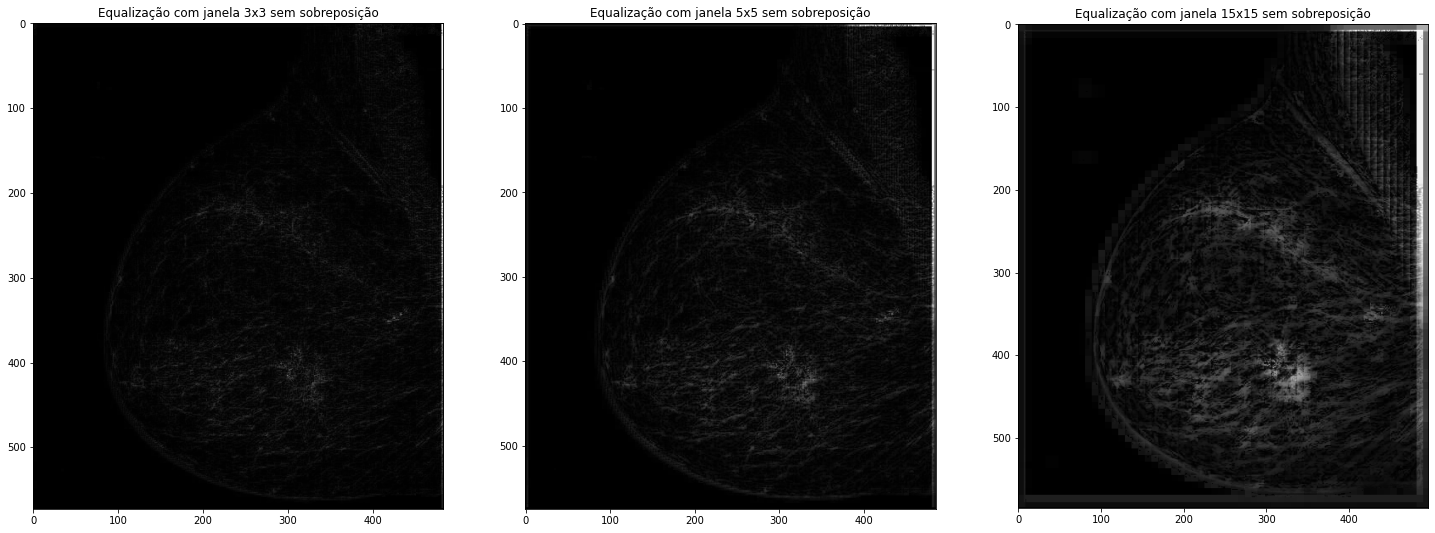

In [ ]:
plt.figure(figsize = (25,10))
plt.subplot(1,3,1)
plt.imshow(breast_eq_no_overlap_three, cmap = "gray")
plt.title("Equalização com janela 3x3 sem sobreposição")

plt.subplot(1,3,2)
plt.imshow(breast_eq_no_overlap_five, cmap = "gray")
plt.title("Equalização com janela 5x5 sem sobreposição")

plt.subplot(1,3,3)
plt.imshow(breast_eq_no_overlap_fft, cmap = "gray")
plt.title("Equalização com janela 15x15 sem sobreposição")

Como esperado, ao não sobrepor as janelas, criam-se artefatos quadriculados na imagem. Isso fica ainda mais perceptível na terceira imagem à direita.

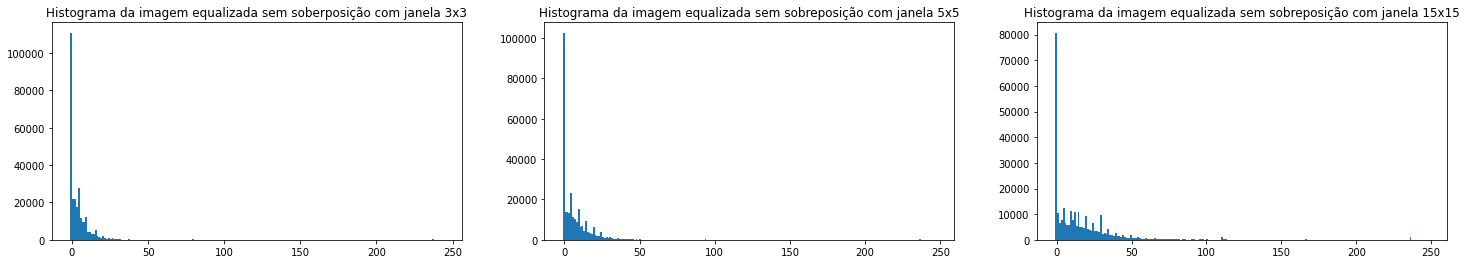

In [ ]:
plt.figure(figsize = (25,4))

plt.subplot(1,3,1)
plt.hist(breast_eq_no_overlap_three.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada sem soberposição com janela 3x3")

plt.subplot(1,3,2)
plt.hist(breast_eq_no_overlap_five.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada sem sobreposição com janela 5x5")

plt.subplot(1,3,3)
plt.hist(breast_eq_no_overlap_fft.ravel(), bins = 200)
plt.title("Histograma da imagem equalizada sem sobreposição com janela 15x15");

### Especificação

In [ ]:
def adaptive_specification_wo_overlap(img, ref_img, window_size = 3):
  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))

  # adicionar bordas na referência
  padded_ref = np.pad(ref_img, pad_pixels, constant_values = (0))
  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)

  # pixels para andar e evitar regiões sobrepostas
  walk_pixels = window_pixels + 1

  for i in range(0, padded_img.shape[0] - pad_pixels, walk_pixels):
    if i > pad_pixels - 1:
      for j in range(0, padded_img.shape[1] - pad_pixels, walk_pixels):
        if j > pad_pixels - 1:

          # equalizando a janela da imagem original
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized, eq_int , orig_int = histogram_equalization(window)

          # equalizando a janela da imagem de referência
          reference_window = padded_ref[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
          equalized_reference, ref_eq_int, ref_orig_int = histogram_equalization(window)

          # inicializando a janela onde ficarão as novas intensidades
          new_specified_window = np.full((window_size, window_size), 0)

          # colocando o mínimo da imagem no 0
          window = window - window.min()

          ## etapa de mapeamento das intensidades originais para as intensidades de referência
          for m in range(window.shape[0]):
            for n in range(window.shape[1]):

              # pega o pixel da janela na imagem original e descobre o seu valor no histograma equalizado local
              position_in_array = np.where(orig_int == window[m][n])[0][0]
              intermediate_px_value = eq_int[position_in_array]

              # procurar por um valor próximo ao do pixel intermediário
              nearest_intensity_value = find_nearest(ref_eq_int, intermediate_px_value)

              # ver qual a localização do pixel com essa intensidade
              position_in_ref_array = np.where(ref_eq_int == nearest_intensity_value)[0][0]
              
              # fazer o mapeamento inverso e descobrir o valor equivalente na imagem de referência
              new_specified_window[m][n] = ref_orig_int[position_in_ref_array]
      
          new_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)] = new_specified_window
  return new_img

In [ ]:
breast_esp_no_overlap_three = adaptive_specification_wo_overlap(img = breast, ref_img = reference_img, window_size = 3)
breast_esp_no_overlap_five = adaptive_specification_wo_overlap(img = breast, ref_img = reference_img, window_size = 5)
breast_esp_no_overlap_fft = adaptive_specification_wo_overlap(img = breast, ref_img = reference_img, window_size = 15)

Text(0.5, 1.0, 'Especificação com janela 15x15 sem sobreposição')

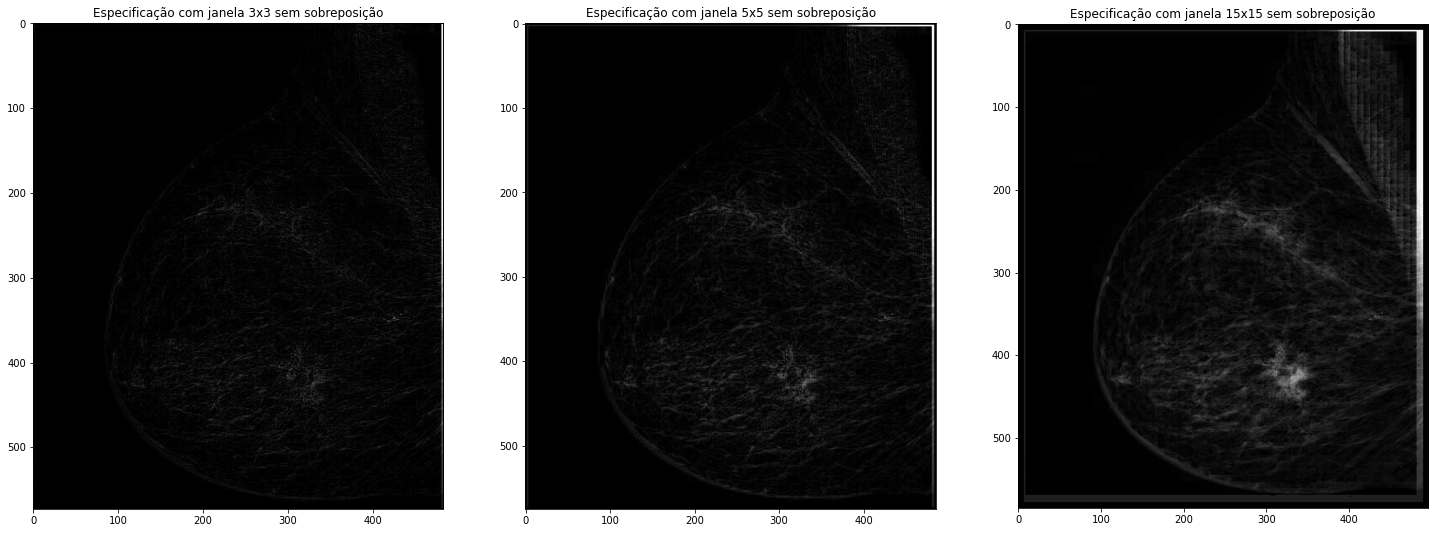

In [ ]:
plt.figure(figsize = (25,10))
plt.subplot(1,3,1)
plt.imshow(breast_esp_no_overlap_three, cmap = "gray")
plt.title("Especificação com janela 3x3 sem sobreposição")

plt.subplot(1,3,2)
plt.imshow(breast_esp_no_overlap_five, cmap = "gray")
plt.title("Especificação com janela 5x5 sem sobreposição")

plt.subplot(1,3,3)
plt.imshow(breast_esp_no_overlap_fft, cmap = "gray")
plt.title("Especificação com janela 15x15 sem sobreposição")

Aqui vemos novamente a criação de artefatos retangulares nas imagens devido à não-sobreposição das janelas.

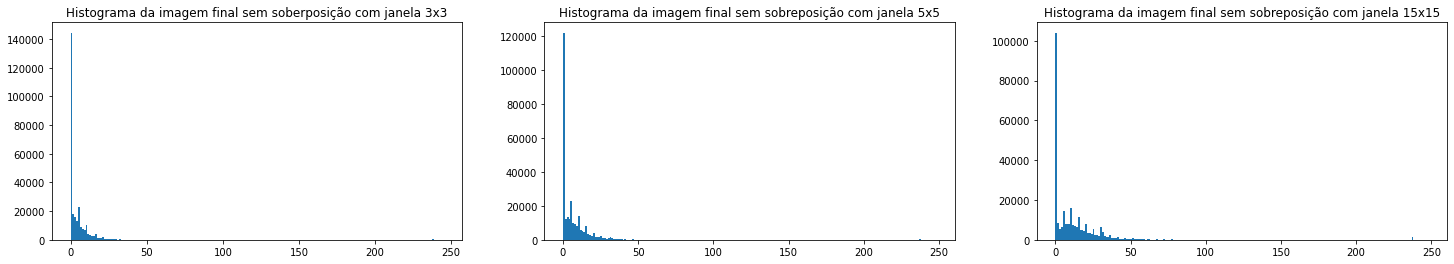

In [ ]:
plt.figure(figsize = (25,4))

plt.subplot(1,3,1)
plt.hist(breast_esp_no_overlap_three.ravel(), bins = 200)
plt.title("Histograma da imagem final sem soberposição com janela 3x3")

plt.subplot(1,3,2)
plt.hist(breast_esp_no_overlap_five.ravel(), bins = 200)
plt.title("Histograma da imagem final sem sobreposição com janela 5x5")

plt.subplot(1,3,3)
plt.hist(breast_esp_no_overlap_fft.ravel(), bins = 200)
plt.title("Histograma da imagem final sem sobreposição com janela 15x15");